###  Прогнозирование уровня средней заработной платы в России

Для выполнения этого задания вам понадобятся данные о среднемесячных уровнях заработной платы в России:

WAG_C_M.csv

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. Если хотите, можете дописать в конец ряда данные за следующие месяцы, если они уже опубликованы; найти эти данные можно, например, здесь.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

Придерживайтесь стандартного алгоритма построения прогноза:

    Визуальный анализ ряда
    Стабилизация дисперсии (при необходимости)
    Выбор порядка дифференцирования
    Выбор начальных приближений для p,q,P,Q 
    Обучение и сравнение моделей-кандидатов, выбор победителя
    Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p,q,P,Q
    Прогнозирование с помощью финальной модели.

Сдать необходимо ipython-ноутбук с проведённым анализом; пожалуйста, комментируйте в ноутбуке каждый важный шаг построения модели.

In [2]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
from sklearn import metrics

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [3]:
data = pd.read_csv('WAG_C_M.csv',';',index_col=['month'], parse_dates=['month'], dayfirst=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 284 entries, 1993-01-01 to 2016-08-01
Data columns (total 1 columns):
WAG_C_M    284 non-null float64
dtypes: float64(1)
memory usage: 4.4 KB


In [5]:
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


In [6]:
data.tail()

,WAG_C_M
month,
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0
2016-07-01,35888.0
2016-08-01,34095.0


#### 1. Визуальный анализ ряда

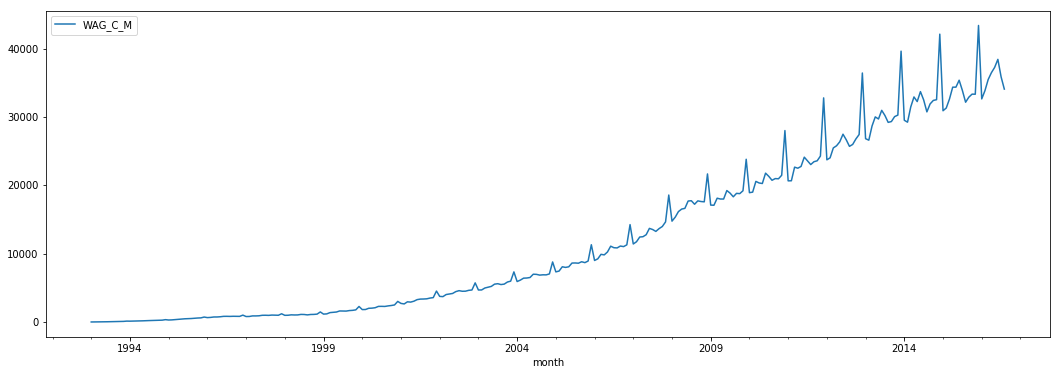

In [7]:
data.plot(figsize=(18,6))

Как видно из графика, ряд является нестационарным: содержит повышательный тренд, выраженную сезонность и увеличивающуюся дисперсию.

Для стабилизации дисперсии выполним преобразование Бокса-Кокса, для устранения тренда и сезонности продиффиренцируем ряд. 

#### 2. Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


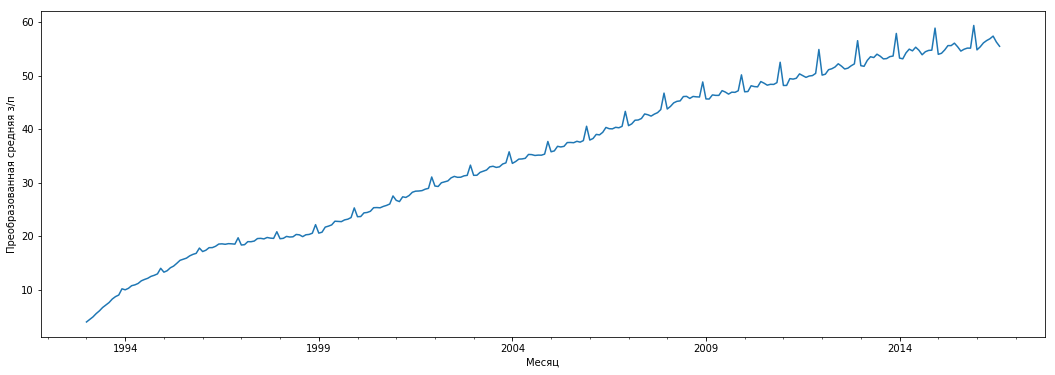

In [8]:
data['WAG_C_M_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(18,6))
data.WAG_C_M_box.plot()
plt.ylabel(u'Преобразованная средняя з/п')
plt.xlabel(u'Месяц')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box)[1])

Дисперсия уменьшилась, но повышательный тренд и сезонность остались.

Для устранения тренда и сезонности выполним сезонное и, при необходимости, обычное дифференцирование.

#### 3. Выбор порядка дифференцирования

Критерий Дики-Фуллера: p=0.014697


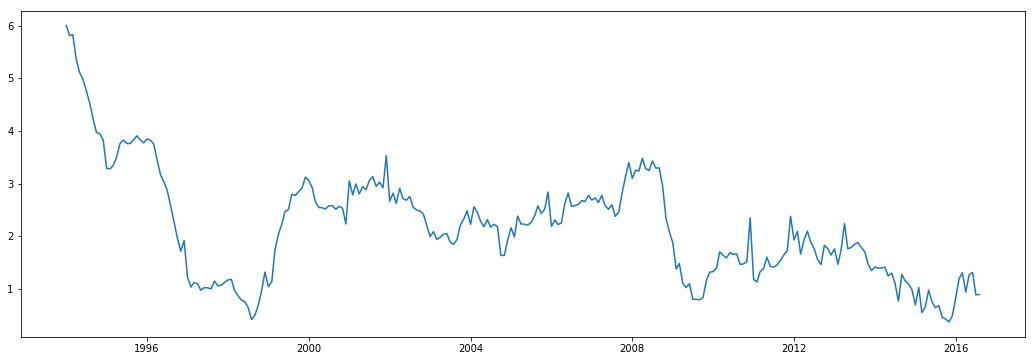

In [9]:
# Сезонное  дифференциорование
data['WAG_C_M_box_diff'] = data.WAG_C_M_box - data.WAG_C_M_box.shift(12)
plt.plot(data.WAG_C_M_box_diff)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff[12:])[1])

После сезонного дифференцирования остался тренд, хотя Критерий Дики-Фуллера отвергает гипотезу нестационарности.

Выполним еще и обычное дифференцирование.

Критерий Дики-Фуллера: p=0.000000


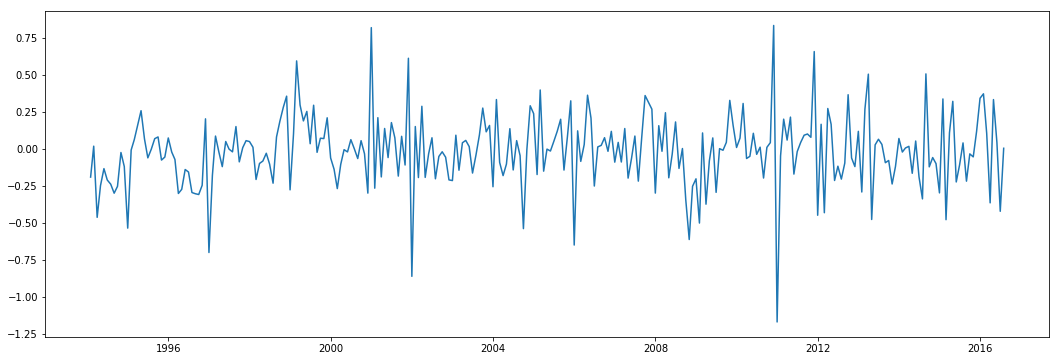

In [10]:
# Обычное  дифференцирование
data['WAG_C_M_box_diff2'] = data.WAG_C_M_box_diff - data.WAG_C_M_box_diff.shift(1)
plt.plot(data.WAG_C_M_box_diff2)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff2[13:])[1])

После второго (обычного) дифференцирования удалось избавиться от тренда. Гипотеза нестационарности также отвергается.

#### 4.Выбор начальных приближений параметров модели SARIMA (p,d,q)x(P,D,Q)

Для выбора начальных значений параметров построим ACF и PACF ряда

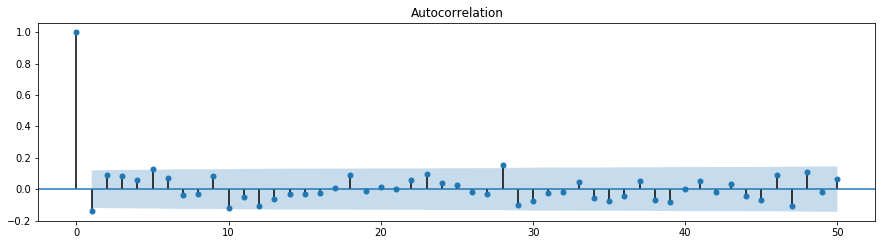

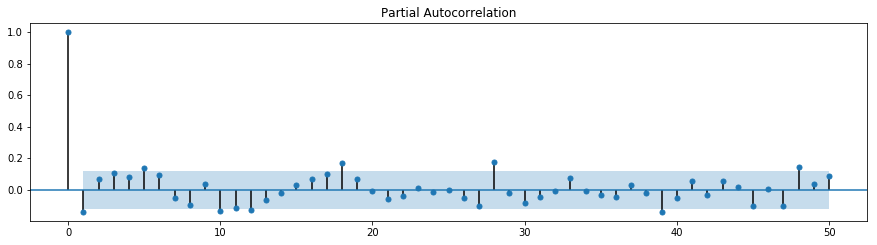

In [11]:
# ACF и PACF полученного ряда
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.WAG_C_M_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.WAG_C_M_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

- Сезонных лагов со значимой автокорреляцией нет, Q=0.
- Последним несезонным лагом со значимой автокорреляцией можно принять q=5.
- Последним сезонным лагом со значимой частичной автокорреляцией можно принять 48, P=4
- Последним несезонным лагом со значимой частичной автокорреляцией можно принять p=5
- Количество обычных дифференцирований d=1
- Количество сезонных дифференцирований D=1


Начальные приближения: Q=0, q=5, P=4, p=5

In [13]:
ps = range(4, 6)
d=1
qs = range(4, 6)
Ps = range(4, 6)
D=1
Qs = range(0, 2)

In [14]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

#### 5. Обучение и сравнение моделей-кандидатов, выбор победителя


In [15]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    except LinAlgError:
        print('LinAlgError:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (4, 4, 4, 0)
wrong parameters: (4, 4, 4, 1)
wrong parameters: (4, 4, 5, 0)
wrong parameters: (4, 4, 5, 1)
wrong parameters: (5, 4, 4, 0)
wrong parameters: (5, 4, 4, 1)
wrong parameters: (5, 4, 5, 0)
wrong parameters: (5, 4, 5, 1)
Wall time: 24min 8s


In [16]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters        aic
3  (4, 5, 5, 1) -28.925303
1  (4, 5, 4, 1) -28.676867
7  (5, 5, 5, 1) -24.130818
5  (5, 5, 4, 1) -23.276016
2  (4, 5, 5, 0) -22.746929


Лучшая модель:

In [17]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(4, 1, 5)x(5, 1, 1, 12)   Log Likelihood                  30.463
Date:                            Tue, 23 Jul 2019   AIC                            -28.925
Time:                                    11:45:52   BIC                             28.709
Sample:                                01-01-1993   HQIC                            -5.785
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6723      0.172      3.906      0.000       0.335       1.010
ar.L2         -0.3905      0.073   

Посмотрим, насколько хорошо модель описывает данные:

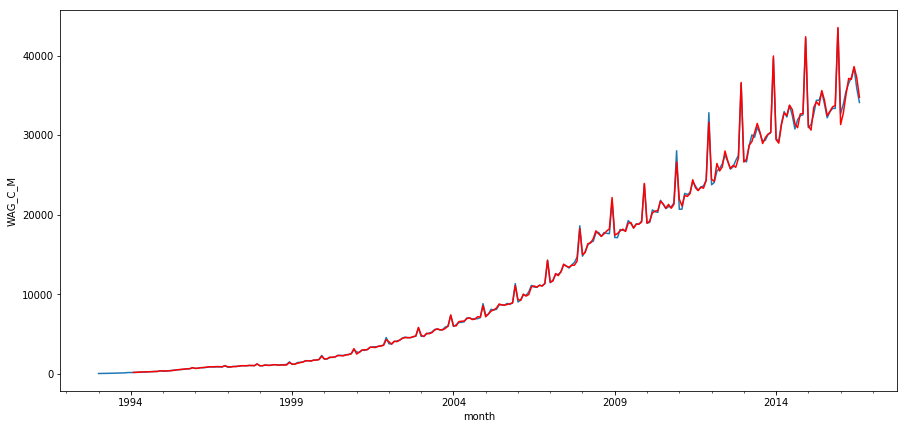

mse= 89778.53120446285  rmse= 299.6306579848979


In [18]:
data['predict']=invboxcox(best_model.predict(), lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
plt.ylabel('WAG_C_M')
data.predict[13:].plot(color='r')
pylab.show()

mser=metrics.mean_squared_error(data.WAG_C_M[13:], data.predict[13:])
print ('mse=', mser,' rmse=', mser**0.5)

Судя по графику и RMSE модель вполне неплохо описывает исходные данные

#### 6. Анализ остатков построенной модели

Посмотрим на "остатки" модели

Критерий Стьюдента: p=0.676405
Критерий Дики-Фуллера: p=0.000000


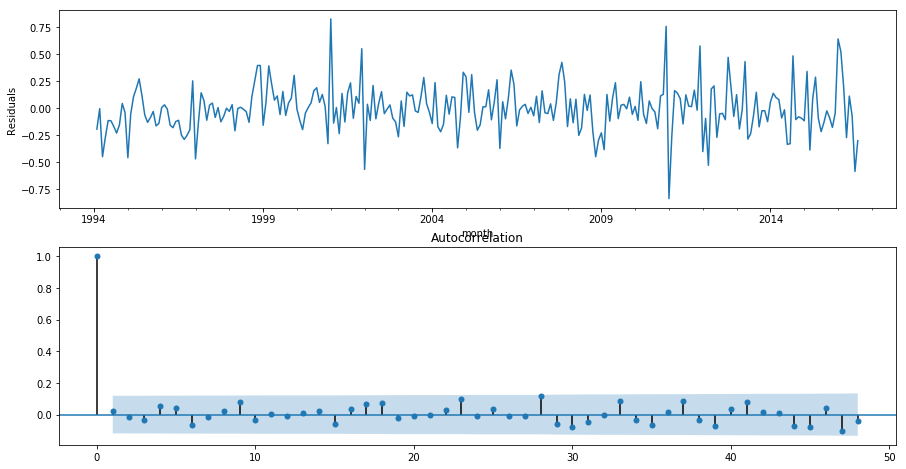

In [20]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [21]:
best_model.resid[13:].mean()

-0.005470720611365307

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается коррелограммой). 

Модель можно использовать для поcтроения прогноза.

#### 7. Прогнозирование с помощью финальной модели

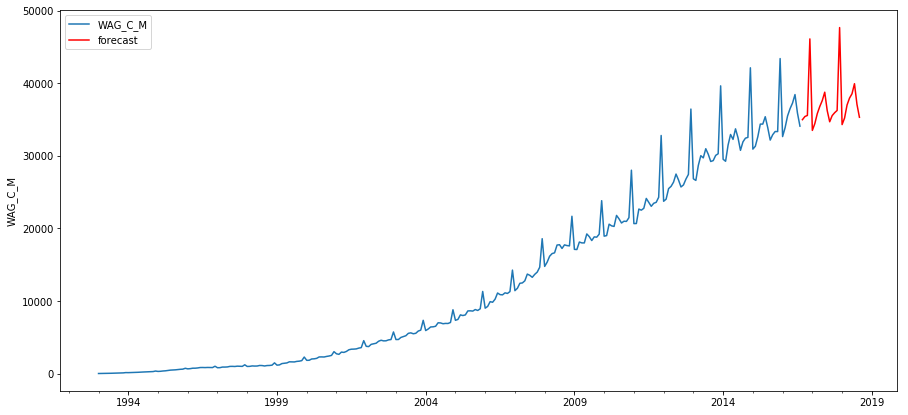

In [24]:
# Продлим исходный временной ряд еще на 24 месяца
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
# Рассчитаем и заполним прогнозные значения
data2['forecast'] = invboxcox(best_model.predict(start=284, end=308), lmbda)
plt.figure(figsize(15,7))
data2.WAG_C_M.plot(legend=True)
data2.forecast.plot(color='r',legend=True)
plt.ylabel('WAG_C_M')
pylab.show()

#### Выводы

ARIMA является мощным средством построения моделей временных рядов, но требует большой работы по приведению раяда к стационарному виду и подбору гиперпараметров модели. 